In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import IPython

import numpy as np
import os
from IPython.display import Image as Image2
from numpy import genfromtxt 
import pickle
from IPython import embed
from PIL import Image, ImageDraw, ImageFont 

import seaborn as sns
import pandas as pd
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches
from scipy.io import loadmat
from scipy.stats import spearmanr
import random

In [2]:
my_data = genfromtxt('../data/sperm-whale-dialogues.csv', delimiter=',',dtype=None,encoding="utf8")
extra_click = pickle.load(open('../data/ornaments.p',"rb"))
rhythms = pickle.load(open("../data/rhythms.p","rb"))
my_data[0,:]

array(['REC', 'nClicks', 'Duration', 'ICI1', 'ICI2', 'ICI3', 'ICI4',
       'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'ICI10', 'ICI11', 'ICI12',
       'ICI13', 'ICI14', 'ICI15', 'ICI16', 'ICI17', 'ICI18', 'ICI19',
       'ICI20', 'ICI21', 'ICI22', 'ICI23', 'ICI24', 'ICI25', 'ICI26',
       'ICI27', 'ICI28', 'Whale', 'TsTo'], dtype='<U15')

In [3]:
TsTo = my_data[1:,-1].astype(float)
whale_id = my_data[1:,-2].astype(int)
file_names = my_data[1:,0]
durs = my_data[1:,2].astype(float)
num_clicks = my_data[1:,1].astype(int)
codas = my_data[1:,3:-2].astype(float)


In [4]:
def getNextCoda(i):
    whale_number = whale_id[i]
    book_start = file_names[i][:6]
    book_next = file_names[min(len(whale_id)-1,i+1)][:6]
    found = -1
    while found==-1 and i<len(whale_id)-1 and book_start==book_next and i<3840:
        i=i+1
        book_next = file_names[i][:6]
        whale_number_i = whale_id[i]
        if whale_number_i==whale_number:
            found = i
    return found

# Function: returns the index for the previous coda (before coda i) from the same whale.
def getPreviousCoda(i):
    found = -1
    whale_number = whale_id[i]
    book_start = file_names[i][:6]
    book_next = file_names[max(0,i-1)][:6]
    while found==-1 and i>0 and book_start==book_next and i>1:
        i=i-1
        book_next = file_names[i][:6]
        whale_number_i = whale_id[i]
        if whale_number_i==whale_number:
            found = i
    return found

def interrupted(i):
    # Start and end times of the 
    st = TsTo[i]
    en = TsTo[i]+durs[i]
    
    if i==my_data.shape[0]-1: # only check the previous   
        return -1

    else: #just check next
        nex = i+1
        
        if nex>=3840:
            return -1

        elif TsTo[nex]<=en and TsTo[nex]>=st:
            return nex
        else:
            return -1

def return_relative(idx,n_clicks):
    rel_ICI = []
    for t in range(3,3+n_clicks):
        rel_ICI.append(np.sum(my_data[idx,3:t].astype(float))/np.sum(my_data[idx,3:3+n_clicks-1].astype(float)))
    return rel_ICI#,np.sum(my_data[idx,3:3+n_clicks-1].astype(float))

# Average absolute drift between (1) adjacent coda pairs and (2) random coda pairs of the same discrete coda type

In [5]:
time_diff = []

tempo_categories = {}

tempo_categories['no-drift'] = []
tempo_categories['drift'] = []
tempo_categories['stop'] = []

for i in range(1,my_data.shape[0]):
    curr_whale = my_data[i,-2].astype(int)
    curr_file = my_data[i,0][:6]
    curr_time = my_data[i,-1].astype(float)
    curr_tempo = my_data[i,2].astype(float)
    curr_clicks = my_data[i,1].astype(int)
    curr_ec = extra_click[i-1]
    immediate = 0
    for j in range(1,5):
        if immediate==0 and i+j<3840:
            next_whale = my_data[i+j,-2].astype(int)
            next_file = my_data[i+j,0][:6]
            next_time = my_data[i+j,-1].astype(float)
            next_tempo = my_data[i+j,2].astype(float)
            next_clicks = my_data[i+j,1].astype(int)
            next_ec = extra_click[i+j-1]

            if next_file==curr_file and next_whale==curr_whale and next_time-curr_time<6 and abs(curr_clicks-next_clicks)<3:
                immediate=1
                if curr_ec>0:
                    curr_tempo=curr_tempo-my_data[i,curr_clicks+2].astype(float)  
                if next_ec>0:
                    next_tempo=next_tempo-my_data[i+j,next_clicks+2].astype(float) 

                if curr_tempo<0:
                    print(curr_tempo)
                else:
                    time_diff.append((curr_tempo,next_tempo,curr_clicks,i)) 
    if immediate==0:
        time_diff.append((curr_tempo,'end'))


In [6]:
difference_of_times = []

for i in range(len(time_diff)):
    if time_diff[i][1]!='end':
        difference_of_times.append(time_diff[i][0]-time_diff[i][1])
np.mean(np.abs(difference_of_times))

0.05380219746883264

Text(0.5, 0, 'Drift in tempo')

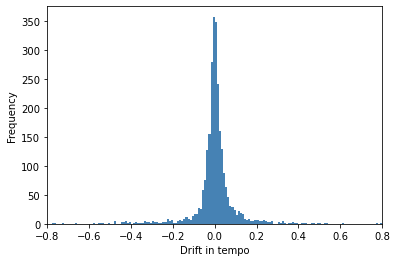

In [7]:
BINS = np.arange(-0.8, 0.8 + 0.01, 0.01)
plt.hist(difference_of_times, density=False, bins=BINS,color='steelblue')  # density=False would make counts
plt.xlim(-0.8,0.8)
plt.ylabel('Frequency')
plt.xlabel('Drift in tempo')

In [8]:
def return_tempo(dur):
    if dur<0.45:
        return 0
    elif dur<0.61:
        return 1
    elif dur<0.93:
        return 2
    elif dur<1.08:
        return 3
    else:
        return 4

buckets = {}
for i in range(1,my_data.shape[0]):
    curr_dur = my_data[i,2].astype(float)
    curr_numclicks = rhythms[i-1]
    if f"{curr_numclicks}-{return_tempo(curr_dur)}" in buckets.keys():
        buckets[f"{curr_numclicks}-{return_tempo(curr_dur)}"].append(curr_dur)
    else:
        buckets[f"{curr_numclicks}-{return_tempo(curr_dur)}"]=[curr_dur]

0.0797520978088402


Text(0.5, 0, 'Drift in tempo')

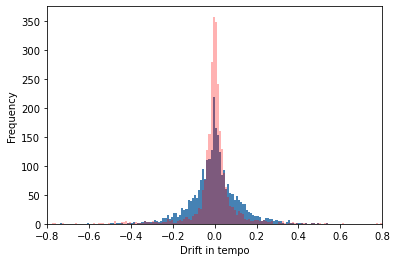

In [9]:
temp = []  
for i in range(len(time_diff)):
    if time_diff[i][1]!='end':
        curr_dur = time_diff[i][0]
        num_clicks = rhythms[time_diff[i][-1]-1]
        ke = f"{num_clicks}-{return_tempo(curr_dur)}"
        k = random.randint(0, len(buckets[ke])-1)
        temp.append(time_diff[i][0]-buckets[ke][k])
plt.hist(temp, density=False, bins=BINS,color='steelblue')  # density=False would make counts
plt.hist(difference_of_times, density=False, bins=BINS,color='red',alpha=0.3) 

print(np.mean(np.abs(temp)))
plt.xlim(-0.8,0.8)
plt.ylabel('Frequency')
plt.xlabel('Drift in tempo')

In [10]:
avg = []
for t in range(10000):
    temp = []  
    for i in range(len(time_diff)):
        if time_diff[i][1]!='end':
            curr_dur = time_diff[i][0]
            num_clicks = rhythms[time_diff[i][-1]-1]
            ke = f"{num_clicks}-{return_tempo(curr_dur)}"
            k = random.randint(0, len(buckets[ke])-1)
            temp.append(time_diff[i][0]-buckets[ke][k])
    avg.append(np.mean(np.abs(temp)))

In [11]:
def compute_quantile(value, data):
    sorted_data = sorted(data)
    length = len(sorted_data)
    
    # Find the position where the value would be inserted
    position = 0
    for i in range(length):
        if sorted_data[i] >= value:
            position = i
            break
        position = length
    
    # Calculate the quantile
    quantile = (position + 1) / length
    
    return quantile

In [12]:
compute_quantile(np.mean(np.abs(difference_of_times)),avg)

0.0001

# Coda triples measured the correlation between tempo drift across adjacent pairs

In [13]:
val_x = []
val_y = []
for i in range(len(durs)):
    tsto_curr = TsTo[i]
    next_id = getNextCoda(i)
    duration_curr = durs[i]
    
    if next_id!=-1:
        tsto_next = TsTo[next_id]
        last_id = getNextCoda(next_id)
        duration_next = durs[next_id]
        
        if last_id!=-1:
            tsto_last = TsTo[last_id]
            duration_last = durs[last_id]
            
            if tsto_last-tsto_curr<15:
                
                val_x.append(duration_last-duration_curr)
                val_y.append(duration_next-duration_curr)

In [14]:
from scipy.stats import spearmanr
coef, p = spearmanr(val_x,val_y)

print(coef,p)

0.5674042057154894 1.839866384490456e-220


# Average absolute difference in duration between (1) pairs of overlapping codas from different whales, and (2) pairs of overlapping codas of the same discrete coda type

In [15]:
overlapping_drifts = []
inter_eq =[]
num_clicks = my_data[1:,1].astype(int)

for i in range(len(extra_click)):
    if extra_click[i]!=1:
        if interrupted(i-1) == i and extra_click[i-1]!=1 and file_names[i][:6]==file_names[i-1][:6]:
            duration_curr = durs[i]
            nclicks_curr = num_clicks[i]
            duration_prev = durs[i-1]
            nclicks_prev = num_clicks[i-1]

            if abs(duration_curr-duration_prev)<0.3:
                overlapping_drifts.append(abs(duration_curr-duration_prev))
                inter_eq.append([duration_prev,duration_curr,i])

print(f"Average difference in coda duration: {np.mean(np.array(overlapping_drifts))}")

Average difference in coda duration: 0.09850273918722786


In [16]:
tempos_ordered= pickle.load(open('../data/tempos-dict.p',"rb"))

    
def compute_quantile(value, data):
    sorted_data = sorted(data)
    length = len(sorted_data)
    
    # Find the position where the value would be inserted
    position = 0
    for i in range(length):
        if sorted_data[i] >= value:
            position = i
            break
        position = length
    
    # Calculate the quantile
    quantile = (position + 1) / length
    
    return quantile

In [17]:
alt_hyp_mean = []
for N in range(10000):
    alternate_hyp = []
    for i in range(len(inter_eq)):
        temp_id = inter_eq[i][1]
        curr_dur = inter_eq[i][1]
        num_clicks = rhythms[inter_eq[i][-1]]
        ke = f"{num_clicks}-{return_tempo(curr_dur)}"
        
        k = random.randint(0, len(buckets[ke])-1)
        alternate_hyp.append(abs(inter_eq[i][0]-buckets[ke][k]))
    alt_hyp_mean.append(np.mean(alternate_hyp))

In [18]:
print(f"Average difference in coda duration:{np.mean(alt_hyp_mean)}")

Average difference in coda duration:0.1189251072302177


In [19]:
compute_quantile(np.mean(np.array(overlapping_drifts)),alt_hyp_mean)

0.0001

In [20]:
# vizualize overlapping codas diff

In [21]:
inter_eq =[]
num_clicks = my_data[1:,1].astype(int)

for i in range(len(extra_click)):
    if extra_click[i]!=1:
        if interrupted(i-1) == i and extra_click[i-1]!=1 and file_names[i][:6]==file_names[i-1][:6]:
            duration_curr = durs[i]
            duration_prev = durs[i-1]
            inter_eq.append([duration_prev,duration_curr])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

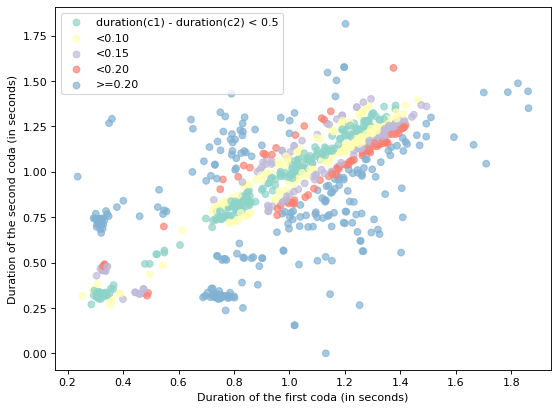

In [22]:
val_x = []
val_y = []
x_y=[]
x_y_abs=[]

# lower_l = 
# upper_l = 
for i in range(len(inter_eq)):
#     if 0<abs(interrupted_codas[i][0]-interrupted_codas[i][1])<0.15:
    x = inter_eq[i][0]
    y = inter_eq[i][1]
    val_x.append(x)
    val_y.append(y)
    x_y_abs.append(abs(x-y))
    x_y.append(x-y)
    
plt.figure(figsize=(8, 6), dpi=80)

col_m = []

for i in range(len(x_y_abs)):
    if x_y_abs[i]<0.05:
        col_m.append(0)
    elif x_y_abs[i]<0.1:
        col_m.append(1)
    elif x_y_abs[i]<0.15:
        col_m.append(2)
    elif x_y_abs[i]<0.2:
        col_m.append(3)
    else:
        col_m.append(4)

color_map = [plt.cm.Set3(i) for i in range(20)]


labels = {}
labels[0] = 'duration(c1) - duration(c2) < 0.5'
labels[1] = '<0.10'
labels[2] = '<0.15'
labels[3] = '<0.20'
labels[4] = '>=0.20'

colrs = []
for i in range(len(col_m)):
    colrs.append(color_map[col_m[i]])
#     colrs.append(next(color_map))
    
for i in range(5):
    plt.scatter(val_x[i],val_y[i],c=color_map[i],alpha=0.7,label = labels[i]) 
    
plt.scatter(val_x,val_y,c=colrs,alpha=0.7) 
plt.xlabel('Duration of the first coda (in seconds)')
plt.ylabel('Duration of the second coda (in seconds)')
#, cmap='rainbow'

plt.legend()

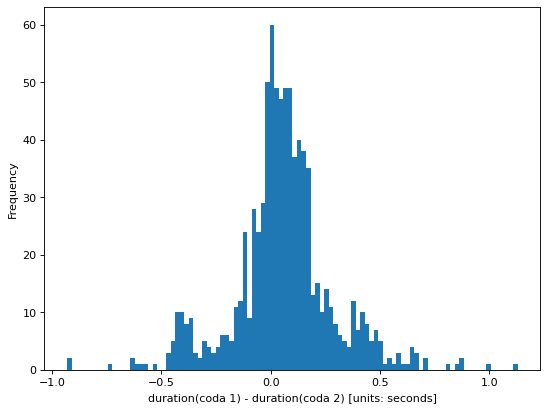

In [23]:
plt.figure(figsize=(8, 6), dpi=80)

plt.hist(x_y, density=False, bins=100)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('duration(coda 1) - duration(coda 2) [units: seconds]');

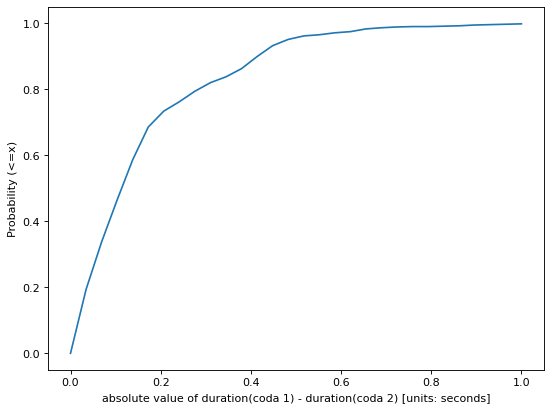

In [24]:
y = []

bins = np.linspace(0, 1, num=30)
for i in list(bins):
    ct = 0
    for j in range(len(x_y_abs)):
        if x_y_abs[j]<=i:
            ct+=1
    y.append(ct/len(x_y_abs))
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(bins,y)
plt.ylabel('Probability (<=x)')
plt.xlabel('absolute value of duration(coda 1) - duration(coda 2) [units: seconds]');

# No Correlation Between Rubato and Behavior

In [25]:
direc = '../data/PRH_all/PRH/' 
# The behavior data can be made available upon request.
prh = [os.path.join(direc, o) for o in os.listdir(direc)]

In [26]:
prh_dict = {}
for i in range(len(prh)):
    loc = prh[i]
    name = 'sw'+os.path.basename(loc)[5:9]
    prh_dict[name] = []
    
for i in range(len(prh)):
    loc = prh[i]
    name = 'sw'+os.path.basename(loc)[5:9]
    prh_dict[name].append(loc)

######################################
window:  0
Correlation of rubato with Accelerometer reading-X
1172 1172
Coefficient: -0.011826062720777674 p-value: 0.6858882352258546
Correlation of rubato with Accelerometer reading-Y
Coefficient: 0.008376459921770265 p-value: 0.7745236642130445
Correlation of rubato with Accelerometer reading-Z
Coefficient: 0.038591157351297166 p-value: 0.18675808917981912
######################################
window:  0.25
Correlation of rubato with Accelerometer reading-X
1172 1172
Coefficient: -0.009543397548719858 p-value: 0.7441428368979814
Correlation of rubato with Accelerometer reading-Y
Coefficient: 0.02078231469141309 p-value: 0.4772147376941268
Correlation of rubato with Accelerometer reading-Z
Coefficient: 0.03633398540775427 p-value: 0.21388316324990575
######################################
window:  0.5
Correlation of rubato with Accelerometer reading-X
1172 1172
Coefficient: -0.00894951340964785 p-value: 0.759558061843263
Correlation of rubato w

/raid/lingo/pratyusha/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


Coefficient: -0.007925371406103526 p-value: 0.7863635373039864
Correlation of rubato with Accelerometer reading-Y
Coefficient: 0.031247724792249524 p-value: 0.28512857307220957
Correlation of rubato with Accelerometer reading-Z
Coefficient: 0.05950993908394911 p-value: 0.041657698329912514
######################################
window:  1
Correlation of rubato with Accelerometer reading-X
1172 1172
Coefficient: -0.008446346402454947 p-value: 0.7726939299337581
Correlation of rubato with Accelerometer reading-Y
Coefficient: 0.03208735769087703 p-value: 0.27237716875403295
Correlation of rubato with Accelerometer reading-Z
Coefficient: 0.059398380119635 p-value: 0.04204258582424113
######################################
window:  2
Correlation of rubato with Accelerometer reading-X
1172 1172
Coefficient: -0.011672548014739523 p-value: 0.6897525720396551
Correlation of rubato with Accelerometer reading-Y
Coefficient: 0.04314964104909966 p-value: 0.1398587913896601
Correlation of rubato wit

<Figure size 720x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

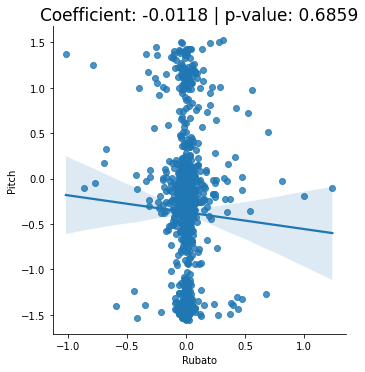

<Figure size 432x288 with 0 Axes>

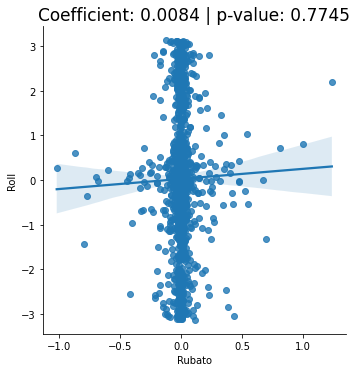

<Figure size 432x288 with 0 Axes>

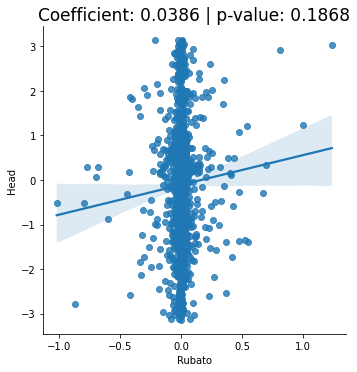

<Figure size 432x288 with 0 Axes>

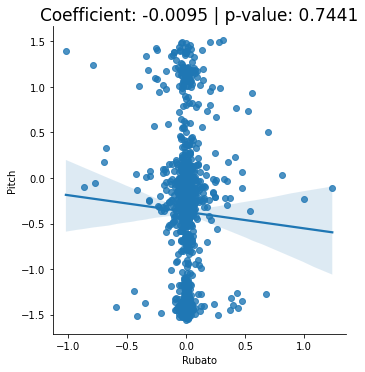

<Figure size 432x288 with 0 Axes>

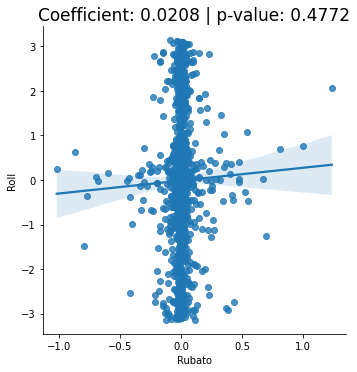

<Figure size 432x288 with 0 Axes>

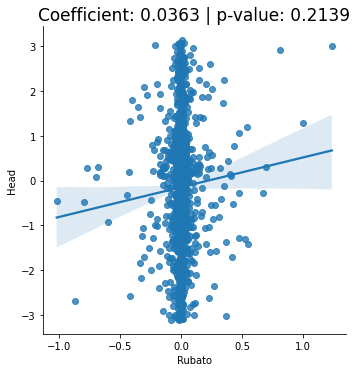

<Figure size 432x288 with 0 Axes>

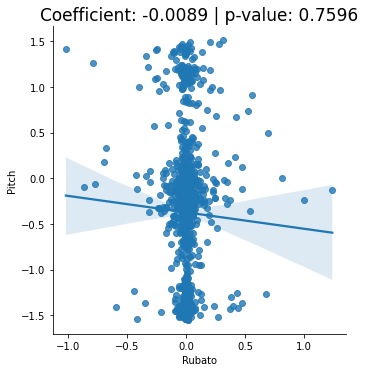

<Figure size 432x288 with 0 Axes>

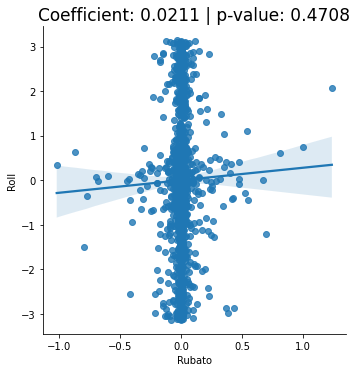

<Figure size 432x288 with 0 Axes>

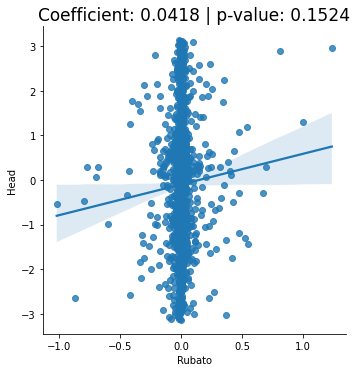

<Figure size 432x288 with 0 Axes>

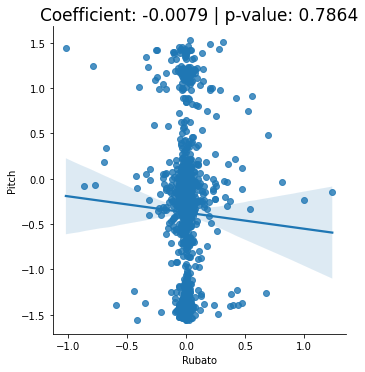

<Figure size 432x288 with 0 Axes>

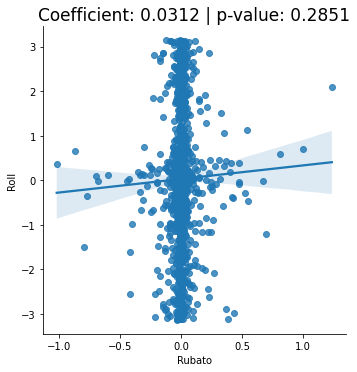

<Figure size 432x288 with 0 Axes>

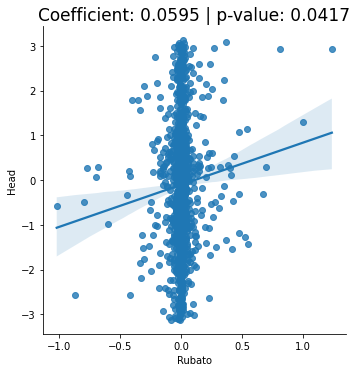

<Figure size 432x288 with 0 Axes>

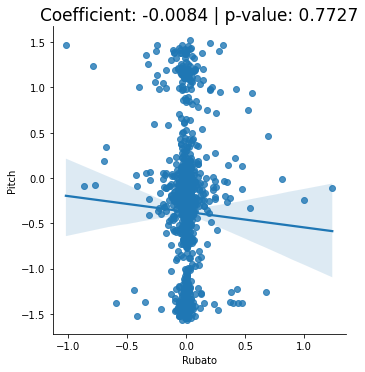

<Figure size 432x288 with 0 Axes>

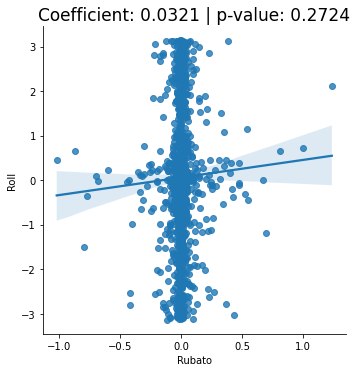

<Figure size 432x288 with 0 Axes>

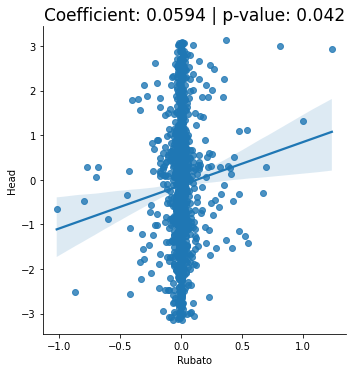

<Figure size 432x288 with 0 Axes>

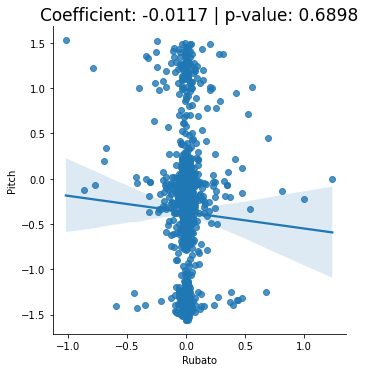

<Figure size 432x288 with 0 Axes>

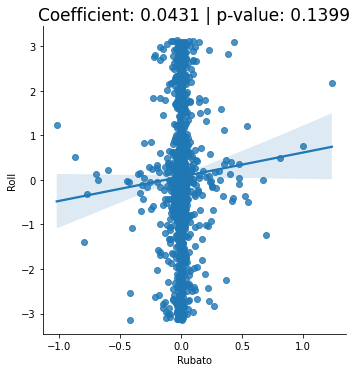

<Figure size 432x288 with 0 Axes>

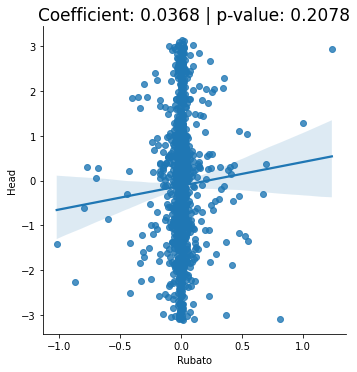

<Figure size 432x288 with 0 Axes>

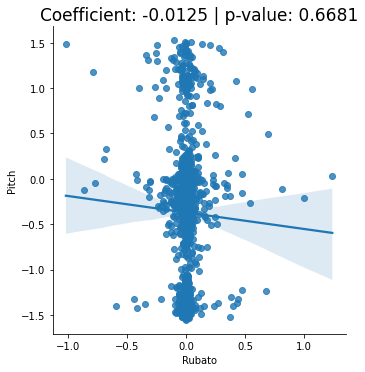

<Figure size 432x288 with 0 Axes>

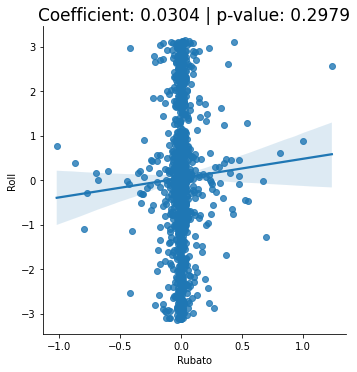

<Figure size 432x288 with 0 Axes>

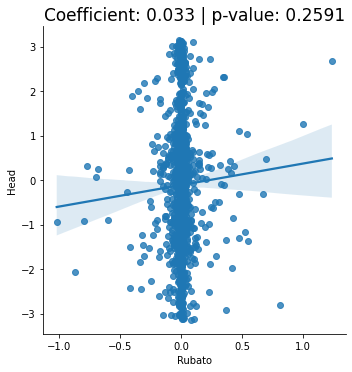

<Figure size 432x288 with 0 Axes>

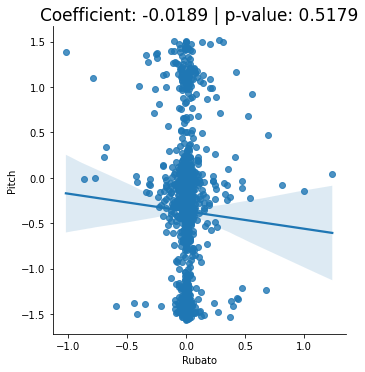

<Figure size 432x288 with 0 Axes>

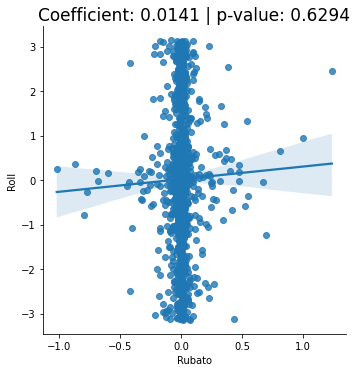

<Figure size 432x288 with 0 Axes>

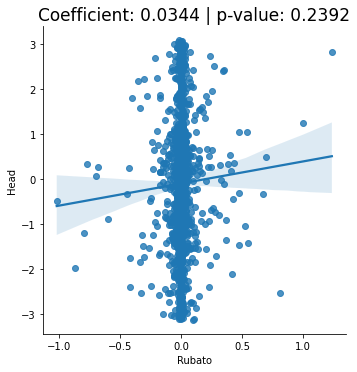

<Figure size 432x288 with 0 Axes>

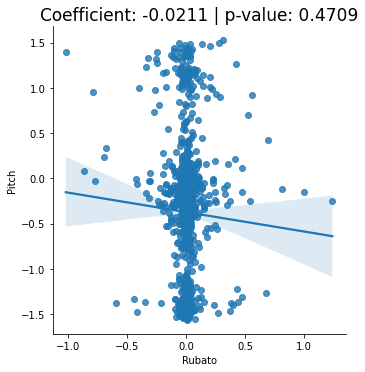

<Figure size 432x288 with 0 Axes>

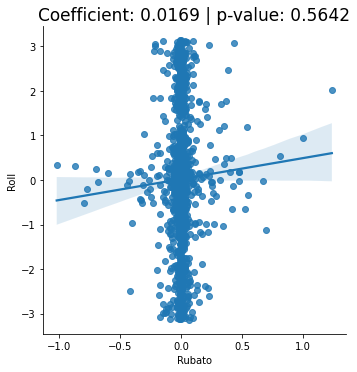

<Figure size 432x288 with 0 Axes>

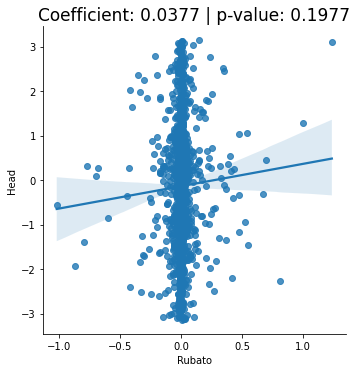

<Figure size 432x288 with 0 Axes>

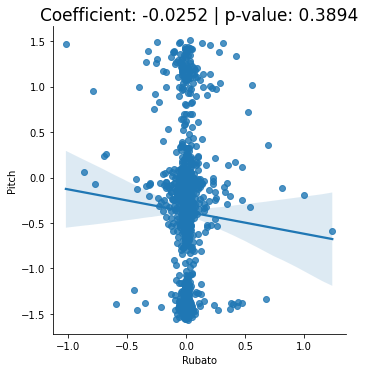

<Figure size 432x288 with 0 Axes>

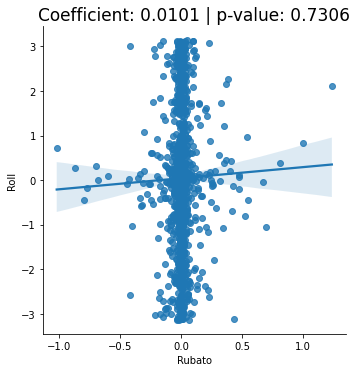

<Figure size 432x288 with 0 Axes>

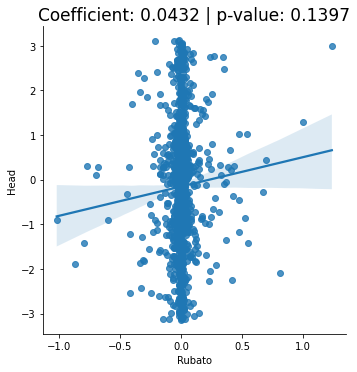

<Figure size 432x288 with 0 Axes>

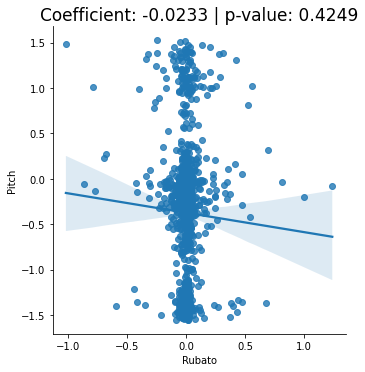

<Figure size 432x288 with 0 Axes>

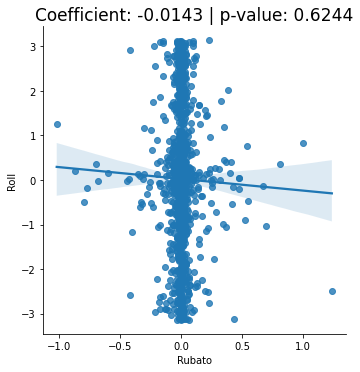

<Figure size 432x288 with 0 Axes>

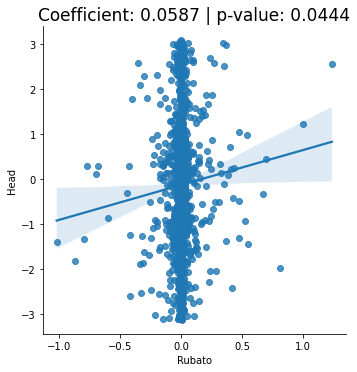

<Figure size 432x288 with 0 Axes>

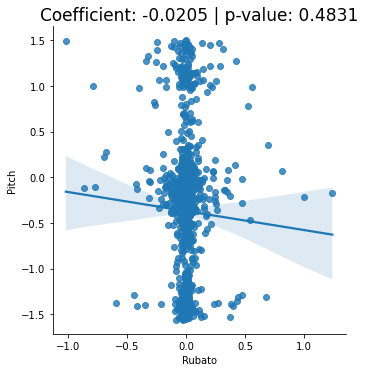

<Figure size 432x288 with 0 Axes>

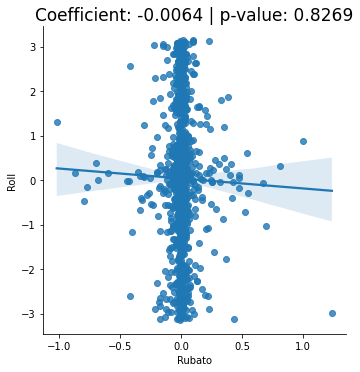

<Figure size 432x288 with 0 Axes>

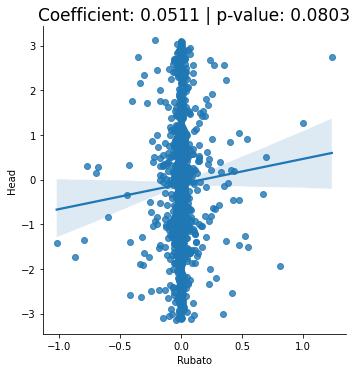

<Figure size 432x288 with 0 Axes>

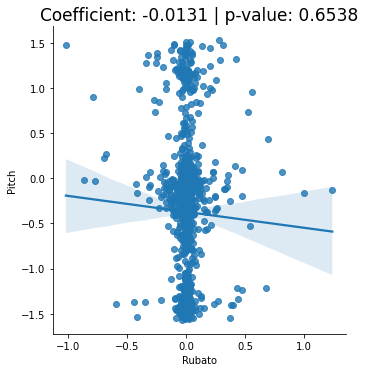

<Figure size 432x288 with 0 Axes>

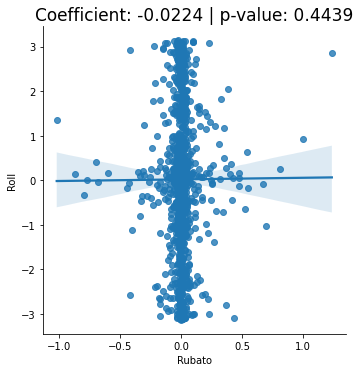

<Figure size 432x288 with 0 Axes>

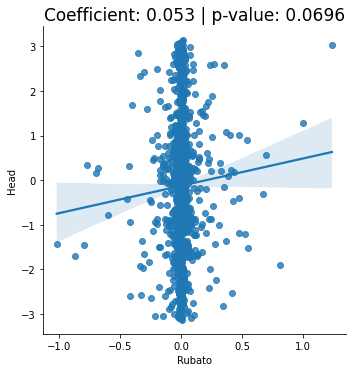

<Figure size 432x288 with 0 Axes>

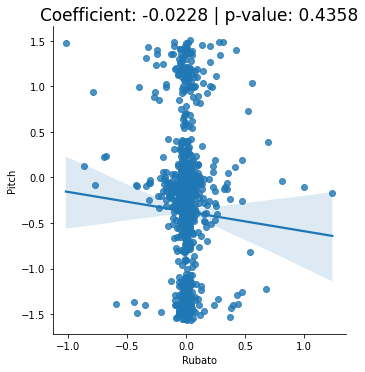

<Figure size 432x288 with 0 Axes>

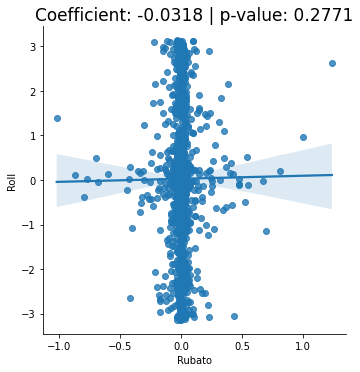

<Figure size 432x288 with 0 Axes>

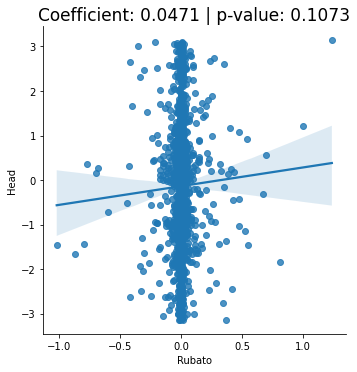

In [27]:
imgs =[]
plt.figure(figsize=(10,6))
for w in [0,0.25,0.5,0.75,1,2,3,4,5,6,7,8,9,10]:
    rubato = []
    accelerometer = []
    for i in range(len(durs)):
        if whale_id[i]==1:
            rootname = file_names[i][:6]
            if i==0 or rootname_o!=rootname:
                x = loadmat(prh_dict[rootname][0])
                rootname_o = rootname
                fs = x['fs'][0][0]
#                 A = x['Aw']
                A = np.concatenate((x['pitch'],x['roll'],x['head']),1)
#                 embed()
            tsto_curr = TsTo[i]
            next_id = getNextCoda(i)
            duration_curr = durs[i]

            A_curr = list(A[int((tsto_curr-w)*fs),:])

            if next_id!=-1:
                tsto_next = TsTo[next_id]
                last_id = getNextCoda(next_id)
                duration_next = durs[next_id]
                A_next = list(A[int((tsto_next-w)*fs),:])

                if tsto_next-tsto_curr<10:
                    rubato.append((duration_next,duration_curr))
                    accelerometer.append((A_next,A_curr))

    rho = []
    acc_X = []
    acc_Y = []
    acc_Z = []

    for i in range(len(rubato)):
        rho.append(rubato[i][0]-rubato[i][1])
        acc_X.append(accelerometer[i][0][0])
        acc_Y.append(accelerometer[i][0][1])
        acc_Z.append(accelerometer[i][0][2])
        
    print('######################################')
    print('window: ', w)
    print("Correlation of rubato with Accelerometer reading-X")
    print(len(acc_X),len(rho))
    
    color_map = []
    plt.figure()
    data = np.stack([rho, acc_X], axis=1)
    df = pd.DataFrame(data, columns=["Rubato", "Pitch"])
    sns.lmplot(x="Rubato", y="Pitch", data=df);
    coef, p = spearmanr(rho,acc_X)
    print("Coefficient:",coef,"p-value:",p)
    plt.title("Coefficient: "+str(round(coef,4))+" | p-value: "+str(round(p,4)),fontsize = 17)
#     plt.savefig('behavior-rubato/'+str(w)+'_X.png',bbox_inches='tight')

    print("Correlation of rubato with Accelerometer reading-Y")
    plt.figure()
    data = np.stack([rho, acc_Y], axis=1)
    df = pd.DataFrame(data, columns=["Rubato", "Roll"])
    sns.lmplot(x="Rubato", y="Roll", data=df);
    coef, p = spearmanr(rho,acc_Y)
    print("Coefficient:",coef,"p-value:",p)
    plt.title("Coefficient: "+str(round(coef,4))+" | p-value: "+str(round(p,4)),fontsize = 17)
#     plt.savefig('behavior-rubato/'+str(w)+'_Y.png',bbox_inches='tight')

    print("Correlation of rubato with Accelerometer reading-Z")
    plt.figure()
    data = np.stack([rho, acc_Z], axis=1)
    df = pd.DataFrame(data, columns=["Rubato", "Head"])
    sns.lmplot(x="Rubato", y="Head", data=df);
    coef, p = spearmanr(rho,acc_Z)
    print("Coefficient:",coef,"p-value:",p)
    plt.title("Coefficient: "+str(round(coef,4))+" | p-value: "+str(round(p,4)),fontsize = 17)
#     plt.savefig('behavior-rubato/'+str(w)+'_Z.png',bbox_inches='tight')
    
    imgs+=['behavior-rubato/'+str(w)+'_X.png','behavior-rubato/'+str(w)+'_Y.png','behavior-rubato/'+str(w)+'_Z.png']